In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def amp_spec(data):
    return abs(np.fft.rfft(data))

In [2]:
!cat setup_default

MODEL_SIZE              '101 101 1'
MODEL_SPACING           '20 20 1'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        vp #'vp rho'
#FILE_TOPO               'topo'

TILD_FROM               'none'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
#FS                      '400 500 0'
FS                      '20 500 0'
#FR                      '400 1500 0'
FR                      '20 1500 0'
DR                      '0  20  0'
#NR                      100
NR                      1

SCOMP                   p
RCOMP                   p #'p vz'

#IF_HICKS        F
#IF_BLOOM        F

NT           500
DT           0.006

## for PFEI ##
#FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'
FILE_DATA_PREFIX    'results_fwd/denv_Shot'
WEIGHTING           'none'

FPEAK        6.4
WAVELET_TYPE        'ricker'
T0                  0.35
UPDATE_WAVELET		'no'
RDT			0

PARAMETER           'vp:1500:2000'
PARAMETER           'tilD:-0.001:0.001'

SMOOTHING     'none'
#PRECO         'z^0'

#JOB        

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory
rm: cannot remove 'results_fwd': No such file or directory
rm: cannot remove 'results_fwd_norefl': No such file or directory


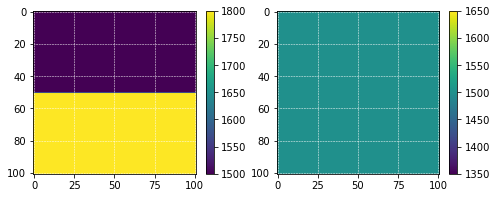

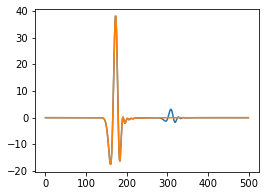

In [2]:
## with reflections
!makevel nz=51 nx=$nx v000=1500 > vp1
!makevel nz=50 nx=$nx v000=1800 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

!makevel nz=1 nx=$nx v000=100 > topo
#!makevel nz=1 nx=$nx v000=400 > topo

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup_default > out_fwd

!rm -r results_fwd; mv results  results_fwd

## w/o reflections
!makevel nz=$nz nx=$nx v000=1500 > model

!../../exe/FWD setup_default > out_fwd_norefl

!rm -r results_fwd_norefl; mv results  results_fwd_norefl

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/dsyn_Shot0001.su'))

**Test PFEI with ricker-wavelet data (NOT envelope data)** 

## PFEI build tilD w/ abs virtual src
### PFEI gradient for tilD

In [3]:
# # with reflections
# !makevel nz=51 nx=$nx v000=1500 > vp1
# !makevel nz=50 nx=$nx v000=1800 > vp2
# !cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
# !rm vp1 vp2 rho1 rho2 tmp*

# w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model

!cp setup_default setup_grad
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad
!echo "IS_ABS_VIRT          T " >> setup_grad

!../../exe/PFEI setup_grad  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


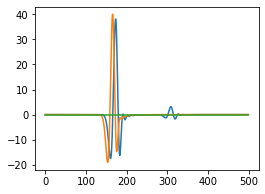

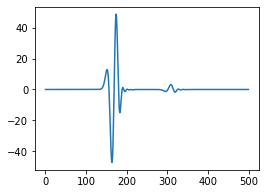

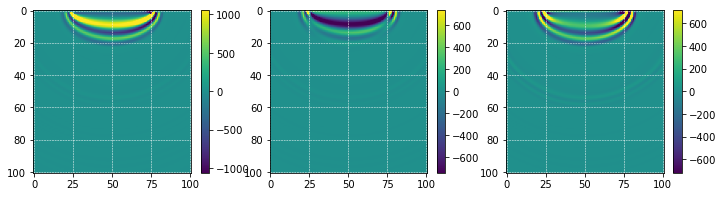

In [4]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=-1000*read('results_grad/F2_star_E0%lap_rp_sp'); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp2=-read('results_grad/F2_star_E0%div_rp_div_sp'); imshow(tmp2,perc=99)
plt.subplot(1,3,3);imshow(tmp1+tmp2,perc=99)

# plt.figure(figsize=(12,3))
# plt.subplot(1,2,1); plt.plot(tmp1[:,50]); plt.plot(tmp2[:,50]); plt.plot(tmp1[:,50]-tmp2[:,50])
# plt.subplot(1,2,2); plt.plot(amp_spec(tmp1[:,50])); plt.plot(amp_spec(tmp2[:,50])); plt.plot(amp_spec(tmp1[:,50]-tmp2[:,50]))

# plt.figure(figsize=(12,3))
# plt.subplot(1,3,1);imshow(signal.medfilt2d(tmp1))
# plt.subplot(1,3,2);imshow(signal.medfilt2d(tmp2))
# plt.subplot(1,3,3);imshow(signal.medfilt2d(tmp1)-signal.medfilt2d(tmp2))

### GradientTest

In [5]:
# w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

#!make App=PFEI

!cp setup_default setup_test
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test
!echo "IS_ABS_VIRT          T " >> setup_test
!echo "FILE_TOPO            topo" >> setup_test
!echo "PARAMETER            'tilD:-0.001:0.001'" >> setup_test
!echo "LS_SCALING           2e-6" >> setup_test
!echo "ALPHAS '1e-4 1e-3 1e-2 1e-1 1 1e1 1e2 1e3' " >> setup_test

!rm -r results
!../../exe/GradientTest  setup_test > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

rm: cannot remove 'results': No such file or directory
            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-05   6.01559989E-02   6.01560101E-02  -1.11758709E-04  -1.51993809E-04   1.36001754     T
 1st cond   1.00000005E-03   6.01558834E-02   6.01560101E-02  -1.26659870E-04  -1.51993809E-04   1.20001554     T
 1st cond   9.99999978E-03   6.01547621E-02   6.01560101E-02  -1.24797225E-04  -1.51993809E-04   1.21792614     T
 1st cond  0.100000001       6.01435527E-02   6.01560101E-02  -1.24573708E-04  -1.51993809E-04   1.22011149     T
 1st cond   1.00000000       6.00324050E-02   6.01560101E-02  -1.23605132E-04  -1.51993809E-04   1.22967231     T
 1st cond   10.0000000       5.89941852E-02   6.01560101E-02  -1.16182491E-04  -1.51993809E-04   1.30823338     T
 1st cond   100.000000       5.59616424E-02   6.01560101E-02  -4.19436765E-05  -1.51993809E-04   3.62375975     T
 1st cond   1000.00000      0.584477365       6.01560

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   10.0000000       5.89941852E-02   6.01560101E-02  -1.16182491E-04  -1.51993809E-04   1.30823338     T


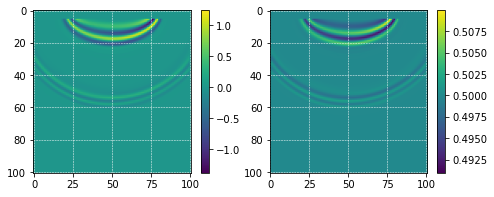

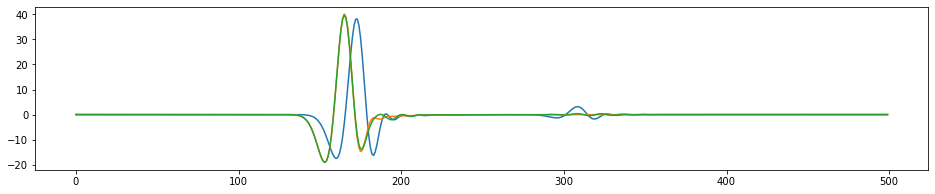

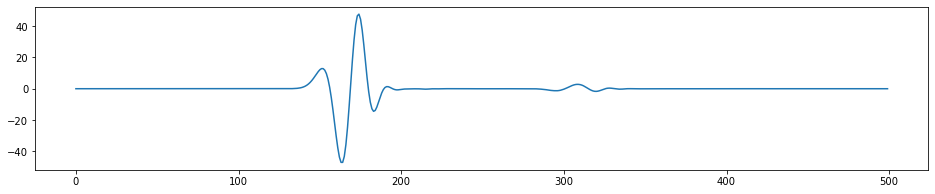

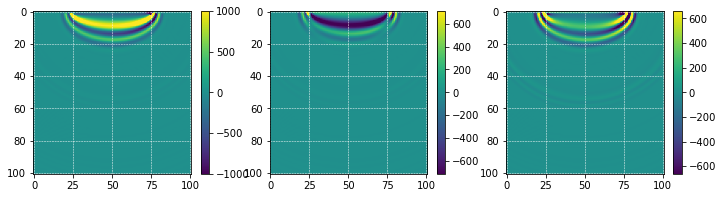

In [6]:
# w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

#!make App=PFEI

!cp setup_default setup_test
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test
!echo "IS_ABS_VIRT         T " >> setup_test
!echo "FILE_TOPO            topo" >> setup_test
!echo "PARAMETER            'tilD:-0.001:0.001'" >> setup_test
!echo "LS_SCALING           2e-6" >> setup_test
!echo "ALPHAS               10 " >> setup_test

!rm -r results
!../../exe/GradientTest  setup_test > out

!cp results/pert%x prior_tilD_scaled
!farith < prior_tilD_scaled op=scale scale=0.002 | farith op=bias bias=-0.001 > tilD

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);imshow(read('results/qp0%pg'))
plt.subplot(1,3,2);imshow(read('results/pert%x'))

plt.figure(figsize=(16,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+read_su('results/RdE_Shot0001.su'))

plt.figure(figsize=(16,3))
plt.plot(read_su('results/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=-1000*read('results/F2_star_E0%lap_rp_sp'); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp2=-read('results/F2_star_E0%div_rp_div_sp'); imshow(tmp2,perc=99)
plt.subplot(1,3,3);imshow(tmp1+tmp2,perc=99)

## PFEI build tilrho (tilrho:=1/tilD) wait..

### Gradient test

In [21]:
# w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

!make App=PFEI

!cp setup_default setup_test
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test
#!echo "IS_ABS_VIRT          T " >> setup_test
!echo "TILD_FROM            inverse_rho" >> setup_test
!echo "FILE_TOPO            topo" >> setup_test
!echo "PARAMETER            'tilrho:500:2500'" >> setup_test
#!echo "LS_SCALING           2e-6" >> setup_test
!echo "ALPHAS '1e-4 1e-3 1e-2 1e-1 1 1e1 1e2 1e3' " >> setup_test

!rm -r results
!../../exe/GradientTest  setup_test > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
mpif90 -cpp -Dgfortran -D"git_commit='11da453'" -D"git_branch='envelope'" -Ofast -fopenmp -ffree-line-length-none -fbacktrace  -fno-unsafe-math-optimizations -frounding-math -fsignaling-nans -J ../../mod/ -c m_model.f90 -o m_model.o


make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJ

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   1.00000000      0.272176504      0.432603449     -0.160426944     -0.193682566       1.20729446     T


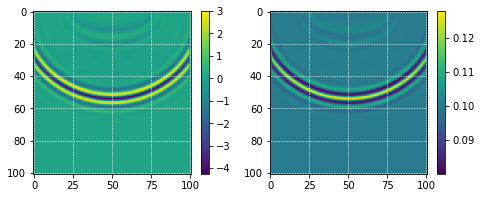

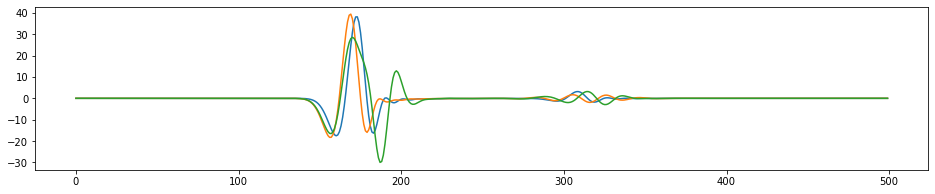

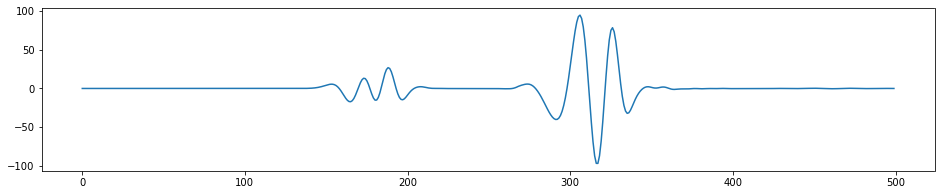

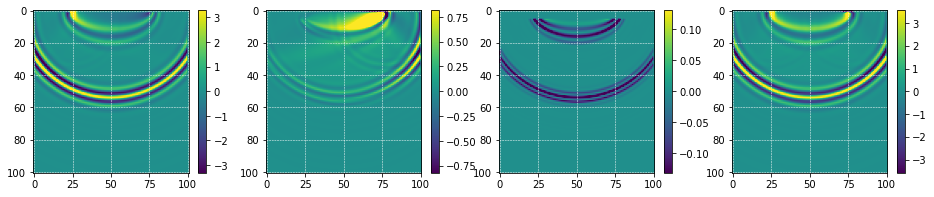

In [105]:
# with nonzero tilD, from running the above cell
!makevel nz=$nz nx=$nx v000=1550 > vp
!cat vp tilD > model

#!make App=PFEI

!cp setup_default setup_test
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test
!echo "MODEL_ATTRIBUTES    'vp tilD'" >> setup_test
!echo "PARAMETER           'vp:1500:2000'" >> setup_test
!echo "JOB                 'update velocity gradient'" >> setup_test
!echo "WEIGHTING           polygon:wei_notEnv" >> setup_test
!echo "ALPHAS               1 " >> setup_test

!rm -r results
!../../exe/GradientTest  setup_test > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);imshow(read('results/qp0%pg'))
plt.subplot(1,3,2);imshow(read('results/pert%x'))

plt.figure(figsize=(16,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+read_su('results/RdE_Shot0001.su'))

plt.figure(figsize=(16,3))
plt.plot(read_su('results/dadj_Shot0001.su'))

plt.figure(figsize=(16,3))
plt.subplot(1,4,1);tmp1=read('results_grad/F1_star_E0%rp_lap_sp'); imshow(tmp1,perc=98)
plt.subplot(1,4,2);tmp2=read('results_grad/F2_star_dE%rp_lap_sp'); imshow(tmp2,perc=98)
plt.subplot(1,4,3);tmp3=1000*tilD*read('results_grad/F2_star_E0%lap_rp_sp'); imshow(tmp3,perc=98)
plt.subplot(1,4,4);imshow(tmp1+tmp2-tmp3,perc=98)